# Olympics (Country Medal Table) — Regression + Clustering

This notebook:
1. Loads and cleans `olympics.csv` (country-level aggregated medal table).
2. Builds **regression models** to predict total medals.
3. Builds **clustering models** to find natural groups of countries by Olympic performance.

> Notes:
- The dataset is *aggregated by country*, not by year or athlete.
- That means forecasting by Olympic year or athlete-level prediction is **not** supported with this file.


In [1]:
import pandas as pd
import numpy as np
import re



df_raw = pd.read_csv("olympics.csv")
df_raw.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,NaN,№ Summer,01 !,02 !,03 !,Total,№ Winter,01 !,02 !,03 !,Total,№ Games,01 !,02 !,03 !,Combined total
1,Afghanistan (AFG),13,0,0,2,2,0,0,0,0,0,13,0,0,2,2
2,Algeria (ALG),12,5,2,8,15,3,0,0,0,0,15,5,2,8,15
3,Argentina (ARG),23,18,24,28,70,18,0,0,0,0,41,18,24,28,70
4,Armenia (ARM),5,1,2,9,12,6,0,0,0,0,11,1,2,9,12


## 1) Clean & prepare the dataset

The CSV has no true header row; the **first row is a duplicated header inside the data**.
We'll:
- Assign column names
- Drop the header-like row
- Parse country names / codes
- Convert numeric columns to integers


In [2]:
# Assign meaningful column names
colnames = [
    "country_raw",
    "summer_games", "summer_gold", "summer_silver", "summer_bronze", "summer_total",
    "winter_games", "winter_gold", "winter_silver", "winter_bronze", "winter_total",
    "total_games", "total_gold", "total_silver", "total_bronze", "total_medals"
]
df = df_raw.copy()
df.columns = colnames

# Drop the embedded header row (where country is NaN or contains '№')
df = df[df["country_raw"].notna()]
df = df[~df["country_raw"].astype(str).str.contains("№", regex=False)]

# Parse country name + optional 3-letter code in parentheses
# Example: "Afghanistan (AFG)"
def split_country(x: str):
    x = str(x).strip()
    m = re.match(r"^(.*?)(?:\s*\(([^)]+)\))?$", x)
    name = m.group(1).strip() if m else x
    code = m.group(2).strip() if (m and m.group(2)) else None
    return name, code

df[["country", "code"]] = df["country_raw"].apply(lambda s: pd.Series(split_country(s)))

# Convert numeric columns
num_cols = [c for c in df.columns if c not in ["country_raw", "country", "code"]]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Drop rows with missing totals
df = df.dropna(subset=["total_medals", "total_games"]).copy()

# Make integer where reasonable
for c in num_cols:
    df[c] = df[c].astype(int)

df = df.reset_index(drop=True)

df.head()


,country_raw,summer_games,summer_gold,summer_silver,summer_bronze,summer_total,winter_games,winter_gold,winter_silver,winter_bronze,winter_total,total_games,total_gold,total_silver,total_bronze,total_medals,country,code
0,Afghanistan (AFG),13,0,0,2,2,0,0,0,0,0,13,0,0,2,2,Afghanistan,AFG
1,Algeria (ALG),12,5,2,8,15,3,0,0,0,0,15,5,2,8,15,Algeria,ALG
2,Argentina (ARG),23,18,24,28,70,18,0,0,0,0,41,18,24,28,70,Argentina,ARG
3,Armenia (ARM),5,1,2,9,12,6,0,0,0,0,11,1,2,9,12,Armenia,ARM
4,Australasia (ANZ) [ANZ],2,3,4,5,12,0,0,0,0,0,2,3,4,5,12,Australasia (ANZ) [ANZ],None


In [3]:
df.describe(include="all").T.head(20)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country_raw,147,147,Afghanistan (AFG),1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
summer_games,147.0,NaN,NaN,NaN,13.47619,7.072359,1.0,8.0,13.0,18.5,27.0
summer_gold,147.0,NaN,NaN,NaN,65.428571,405.54999,0.0,0.0,3.0,24.0,4809.0
summer_silver,147.0,NaN,NaN,NaN,64.965986,399.30996,0.0,1.0,4.0,28.0,4775.0
summer_bronze,147.0,NaN,NaN,NaN,69.795918,427.187344,0.0,1.0,6.0,29.0,5130.0
summer_total,147.0,NaN,NaN,NaN,200.190476,1231.306297,0.0,2.0,12.0,86.0,14714.0
winter_games,147.0,NaN,NaN,NaN,6.70068,7.433186,0.0,0.0,5.0,10.0,22.0
winter_gold,147.0,NaN,NaN,NaN,13.047619,80.799204,0.0,0.0,0.0,1.0,959.0
winter_silver,147.0,NaN,NaN,NaN,13.034014,80.634421,0.0,0.0,0.0,2.0,958.0
winter_bronze,147.0,NaN,NaN,NaN,12.897959,79.588388,0.0,0.0,0.0,1.0,948.0


## 2) Feature engineering

We'll add a few interpretable metrics:
- **medals_per_game**: how efficient a country is per Olympic participation (overall)
- **gold_ratio**: share of gold among all medals
- **summer_share / winter_share**: dependency on Summer vs Winter medals


In [4]:
df["medals_per_game"] = df["total_medals"] / df["total_games"].replace(0, np.nan)
df["gold_ratio"] = df["total_gold"] / df["total_medals"].replace(0, np.nan)

df["summer_share"] = df["summer_total"] / df["total_medals"].replace(0, np.nan)
df["winter_share"] = df["winter_total"] / df["total_medals"].replace(0, np.nan)

df[["country","total_games","total_medals","medals_per_game","gold_ratio","summer_share","winter_share"]].head(10)


,country,total_games,total_medals,medals_per_game,gold_ratio,summer_share,winter_share
0,Afghanistan,13,2,0.153846,0.000000,1.000000,0.000000
1,Algeria,15,15,1.000000,0.333333,1.000000,0.000000
2,Argentina,41,70,1.707317,0.257143,1.000000,0.000000
3,Armenia,11,12,1.090909,0.083333,1.000000,0.000000
4,Australasia (ANZ) [ANZ],2,12,6.000000,0.250000,1.000000,0.000000
5,Australia (AUS) [AUS] [Z],43,480,11.162791,0.300000,0.975000,0.025000
6,Austria,48,304,6.333333,0.253289,0.282895,0.717105
7,Azerbaijan,10,26,2.600000,0.230769,1.000000,0.000000
8,Bahamas,15,12,0.800000,0.416667,1.000000,0.000000
9,Bahrain,8,1,0.125000,0.000000,1.000000,0.000000


# 🟦 Part A — Regression

### Goal
Predict a country's **total medals** from participation history.

We'll try:
- Linear Regression (baseline)
- Ridge Regression (handles collinearity)
- Random Forest Regressor (nonlinear baseline)

We'll evaluate with:
- **R²** (higher is better)
- **RMSE** (lower is better)


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

# Simple, interpretable features (you can expand later)
X = df[["summer_games", "winter_games", "total_games"]].copy()
y = df["total_medals"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

models = {
    "LinearRegression": LinearRegression(),
    "Ridge(alpha=1.0)": Ridge(alpha=1.0, random_state=42),
    "RandomForest": RandomForestRegressor(
        n_estimators=400, random_state=42, min_samples_leaf=2
    ),
}

results = []
preds = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    preds[name] = y_pred
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    results.append((name, r2, rmse))

pd.DataFrame(results, columns=["model", "R2", "RMSE"]).sort_values("R2", ascending=False)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,model,R2,RMSE
2,RandomForest,0.333297,365.230340
1,Ridge(alpha=1.0),0.145439,413.496741
0,LinearRegression,0.145411,413.503570


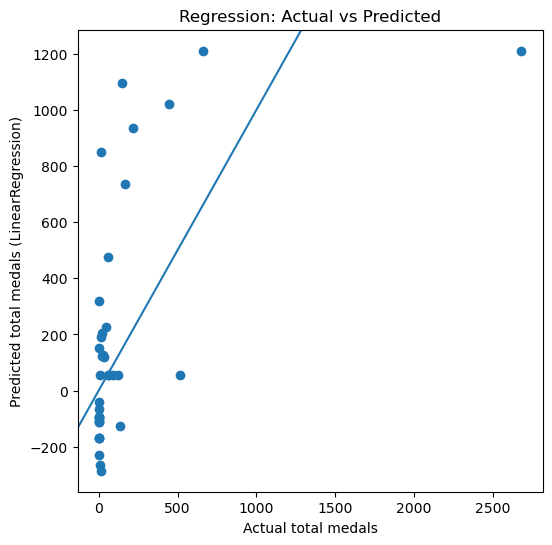

In [6]:
# Visual check: predicted vs actual
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, preds["LinearRegression"])
plt.xlabel("Actual total medals")
plt.ylabel("Predicted total medals (LinearRegression)")
plt.title("Regression: Actual vs Predicted")
plt.axline((0,0), slope=1)
plt.show()


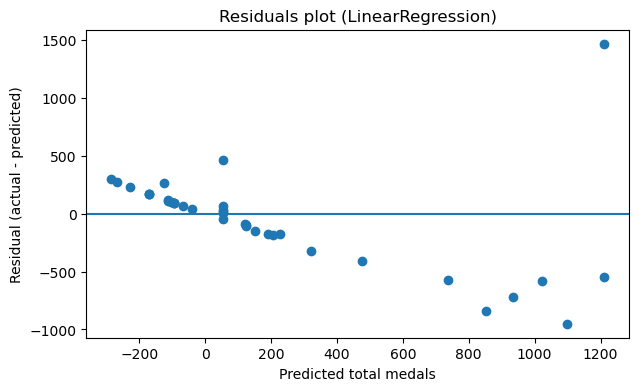

In [7]:
# Residuals (Linear Regression)
residuals = y_test - preds["LinearRegression"]

plt.figure(figsize=(7,4))
plt.scatter(preds["LinearRegression"], residuals)
plt.axhline(0)
plt.xlabel("Predicted total medals")
plt.ylabel("Residual (actual - predicted)")
plt.title("Residuals plot (LinearRegression)")
plt.show()


### Feature importance (Random Forest)

This shows which participation features drive predictions the most.


In [8]:
rf = models["RandomForest"]
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

importances


total_games     0.626285
winter_games    0.201663
summer_games    0.172052
dtype: float64

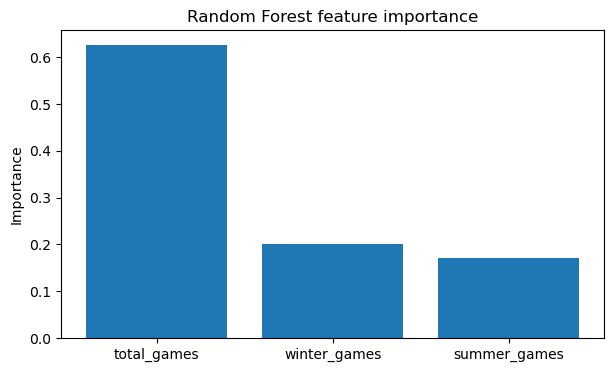

In [9]:
plt.figure(figsize=(7,4))
plt.bar(importances.index, importances.values)
plt.title("Random Forest feature importance")
plt.ylabel("Importance")
plt.show()


# 🟩 Part B — Clustering

### Goal
Group countries by **performance patterns**, not just raw totals.

We cluster on scaled features:
- `total_games`
- `medals_per_game`
- `gold_ratio`
- `summer_share`
- `winter_share`

Then:
- Choose k using silhouette score
- Visualize clusters in 2D using PCA


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

cluster_features = df[["total_games","medals_per_game","gold_ratio","summer_share","winter_share"]].copy()
cluster_features = cluster_features.replace([np.inf, -np.inf], np.nan).dropna().copy()

scaler = StandardScaler()
Xc = scaler.fit_transform(cluster_features)

# Try several k values and score with silhouette
ks = range(2, 7)
scores = []
models_k = {}

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(Xc)
    score = silhouette_score(Xc, labels)
    scores.append((k, score))
    models_k[k] = km

pd.DataFrame(scores, columns=["k","silhouette"]).sort_values("silhouette", ascending=False)


,k,silhouette
1,3,0.549445
0,2,0.529013
4,6,0.439118
3,5,0.427205
2,4,0.366946


In [11]:
# Pick the best k by silhouette score
best_k = max(scores, key=lambda t: t[1])[0]
best_k


3

In [12]:
km = models_k[best_k]
labels = km.predict(Xc)

clustered = cluster_features.copy()
clustered["cluster"] = labels
clustered["country"] = df.loc[clustered.index, "country"].values

clustered.groupby("cluster")[["total_games","medals_per_game","gold_ratio","summer_share","winter_share"]].mean().round(3)


,total_games,medals_per_game,gold_ratio,summer_share,winter_share
cluster,,,,,
0,18.267,4.649,0.205,0.978,0.022
1,49.000,358.755,0.328,0.837,0.163
2,34.933,8.089,0.277,0.573,0.427


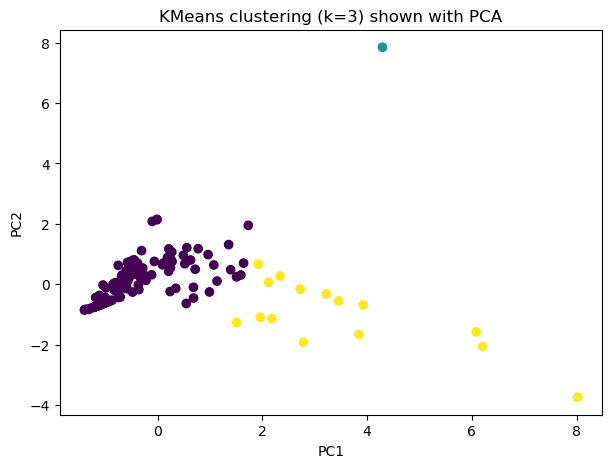

In [13]:
# PCA visualization (2D)
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(Xc)

plt.figure(figsize=(7,5))
plt.scatter(X2[:,0], X2[:,1], c=labels)
plt.title(f"KMeans clustering (k={best_k}) shown with PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [14]:
# Inspect the top 'medals_per_game' countries within each cluster
clustered.sort_values(["cluster","medals_per_game"], ascending=[True, False]).groupby("cluster").head(10)[
    ["country","total_games","medals_per_game","gold_ratio","summer_share","winter_share","cluster"]
]


,country,total_games,medals_per_game,gold_ratio,summer_share,winter_share,cluster
107,Unified Team (EUN) [EUN],2,67.500000,0.400000,0.829630,0.170370,0
106,Soviet Union (URS) [URS],18,66.888889,0.392857,0.838870,0.161130,0
135,United States (USA) [P] [Q] [R] [Z],48,55.854167,0.399851,0.894815,0.105185,0
46,East Germany (GDR) [GDR],11,47.181818,0.369942,0.788054,0.211946,0
104,Russia (RUS) [RUS],11,47.181818,0.348748,0.761079,0.238921,0
23,China (CHN) [CHN],19,27.684211,0.404943,0.899240,0.100760,0
45,United Team of Germany (EUA) [EUA],6,22.833333,0.262774,0.861314,0.138686,0
47,West Germany (FRG) [FRG],11,22.090909,0.275720,0.839506,0.160494,0
49,Great Britain (GBR) [GBR] [Z],49,16.448980,0.305211,0.967742,0.032258,0
41,France (FRA) [O] [P] [Z],49,15.918367,0.298718,0.860256,0.139744,0


## Interpretation ideas (portfolio-ready)

- **Regression:** participation is a strong driver of medal totals; residuals highlight over-/under-performing countries.
- **Clustering:** separates countries into tiers by efficiency and specialization (summer-heavy vs winter-heavy).

### Next improvements (optional)
- Model `log1p(total_medals)` to reduce heavy-tail skew.
- Add additional external covariates (GDP, population) if you merge another dataset.
